In [1]:
import numpy as np
import pandas as pd
from pysr import PySRRegressor
from IPython.display import HTML
from matplotlib import pyplot as plt

from hyperfit.linfit import LinFit

In [2]:
df = pd.read_csv('SMBH_Data_0303.csv',header=1)

In [3]:
df.columns

Index(['ID', 'Galaxy', 'Morphology', 'Type', 'ETG', 'Leda Type', 'T-type',
       'T-type_std', 'Arm Class', 'Bar',
       ...
       'm21c', 'm21c_std', 'hic', 'hic_std', 'mabs', 'mabs_std', 'blum',
       'blum_std', 'logblum', 'logblum_std'],
      dtype='object', length=183)

In [4]:
def fit(paras,bounds,plot=True):
    paras.append('M_BH')
    stds=[]
    for para in paras:
        stds.append(para+'_std')
    
    df_=df[paras+stds].dropna(axis='index',how='any')
    xs=np.array(df_[paras]).transpose()
    errs=np.array(df_[stds]).transpose()
    cov=np.zeros((len(paras),len(paras),len(df_)))
    for i in range(len(paras)):
        cov[i,i,:]=errs[i]**2

    hf = LinFit(xs, cov)

    mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=False)
    print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))
    
    
    if plot:
        c=np.mean(mcmc_samples, axis=1)
        y=xs[-1]
        y_pred=0
        for i in range(len(c)-2):
            y_pred+=c[i]*xs[i]
        y_pred+=c[-2]

    plt.figure(figsize=(8,6))
    plt.scatter(y,y_pred,label='predicted')
    plt.plot(np.linspace(y_pred.min(),y_pred.max()),np.linspace(y_pred.min(),y_pred.max()),ls='--',label='f(x)=x')
    plt.xlabel(r'True $\rm{log} M_{BH}$',fontsize=20)
    plt.ylabel(r'Predicted $\rm{log} M_{BH}$',fontsize=20)
    plt.legend()
    plt.show()
    
    w = 1/errs[-1]**2
    print('rmse:',np.sqrt(np.average((y-y_pred)**2,weights=w)))
    return np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1)

In [5]:
def norm_relation(log_sigma0,log_B_T,logRho_soi):    
    a=2.85425535
    x1norm=2.2771162
    b=1.16151575
    x2norm=-0.35953965
    c=-0.3337952
    x3norm=2.77884623
    d=8.20260696
    return a*(log_sigma0)+b*(log_B_T)+c*(logRho_soi)+d-a*x1norm-b*x2norm-c*x3norm

In [6]:
def rmse(y,y_pred):
    return np.sqrt(np.average((y-y_pred)**2))

def wrmse(y,y_pred,w):
    return np.sqrt(np.average((y-y_pred)**2,weights=w))

def plot_relation(paras,relation,obs=pd.read_csv('SMBH_Data_0303.csv',header=1)):
    if paras[-1]!='M_BH':
        paras.append('M_BH')
        
    paras.append('M_BH_std')
    
    obs = obs[paras].dropna(axis='index',how='any')
    
    print(len(obs))
    
    y=obs['M_BH'].to_numpy()
    yerr=obs['M_BH_std'].to_numpy()
    
    x=[]
    for i in range(len(paras)-2):
        x.append(obs.iloc[:,i].to_numpy())
    
    y_pred=relation(*x)
    
    # f(x)=x line
    minrange=np.array([y.min(),y_pred.min()]).min()
    maxrange=np.array([y.max(),y_pred.max()]).max()
    fs=20
    plt.figure(figsize=(12,8))
    plt.plot(np.linspace(minrange,maxrange),np.linspace(minrange,maxrange),label='f(x)=x',c='r',ls='--')
    #plt.scatter(y,y_pred,label='Observations',alpha=0.8)
    plt.errorbar(y,y_pred,xerr=yerr,label='Observations',alpha=0.8,fmt='o',capsize=3,ecolor='grey')
    
    plt.xlabel(r'True $\rm{log} M_{BH}[M_\odot]$',fontsize=fs)
    plt.ylabel(r'Predicted $\rm{log} M_{BH}[M_\odot]$',fontsize=fs)
    plt.legend(fontsize=fs)
    plt.show()
    
    w = 1/yerr**2
    print('obs rmse:',rmse(y,y_pred))
    print('obs wrmse:',wrmse(y,y_pred,w))

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})=\alpha \log (\frac{\sigma_0}{189}) + \beta \log (\frac{B/T}{0.437}) + \gamma \log (\frac{\rho_\text{soi}}{601}) + \delta
\end{equation}

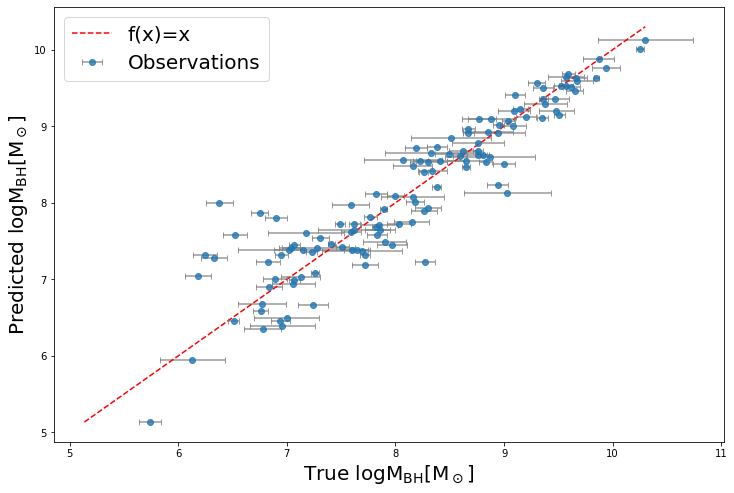

obs rmse: 0.39178933616033157
obs wrmse: 0.269626123045062


In [73]:
plot_relation(['log_sigma0','log_B/T','logRho_soi_approx_new'],norm_relation)

In [54]:
def plot_3d(x,y,z,c,elev=30):
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)
    c=np.array(c)
    
    fs=20
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev)

    plot = ax.scatter(x, y, z,c=c, alpha=0.4, s=10, label=r'$\rm{log} M_{BH}[M_\odot]$')
    
    ax.set_xlabel(r'$\rm{log} \sigma_{0}$',fontsize=fs)
    ax.set_ylabel(r'$\rm{log} B/T$',fontsize=fs)
    ax.set_zlabel(r'$\rm{log} \rho_{soi}$',fontsize=fs)
    #ax.set_box_aspect([np.ptp(i) for i in (x,y,z)]) 
    fig.colorbar(plot, ax=ax)
    plt.legend(fontsize=fs)
    plt.show()    
    return None

In [43]:
obs = df[['log_sigma0','log_B/T','logRho_soi_approx_new']].dropna(axis='index',how='any')
obs['log_sigma0'].min(),obs['log_sigma0'].max(),obs['log_B/T'].min(),obs['log_B/T'].max(),obs['logRho_soi_approx_new'].min(),obs['logRho_soi_approx_new'].max()

(1.538950562, 2.594436751, -1.18, 0.0, 0.484589816, 5.066839139)

In [65]:
xmin,xmax=1,4
ymin,ymax=-2,0
zmin,zmax=0,8
bins=30
x=np.linspace(xmin,xmax,bins)
y=np.linspace(ymin,ymax,bins)
z=np.linspace(zmin,zmax,bins)

In [66]:
xx,yy,zz=np.meshgrid(x,y,z)

In [67]:
c = norm_relation(xx,yy,zz)

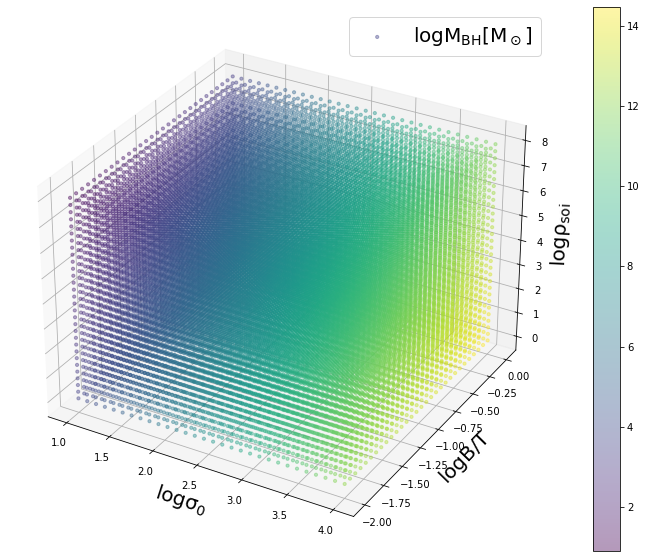

In [68]:
plot_3d(xx,yy,zz,c)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})=2.57 \log \sigma_0 + 0.38 (\log R_e - \log \rho_\text{soi}) + bvc + 2.61
\end{equation}

In [74]:
def sigma_r_rho_bvc_relation(log_sigma0,log_R_e_sph_eq_kpc,logRho_soi_approx_new,bvtc):    
    a=2.5665281441619349
    b=0.37680597349565176
    c=-0.37680597349565176
    d=1.0
    e=2.6084185089278386
    return a*(log_sigma0)+b*(log_R_e_sph_eq_kpc)+c*(logRho_soi_approx_new)+d*(bvtc)+e

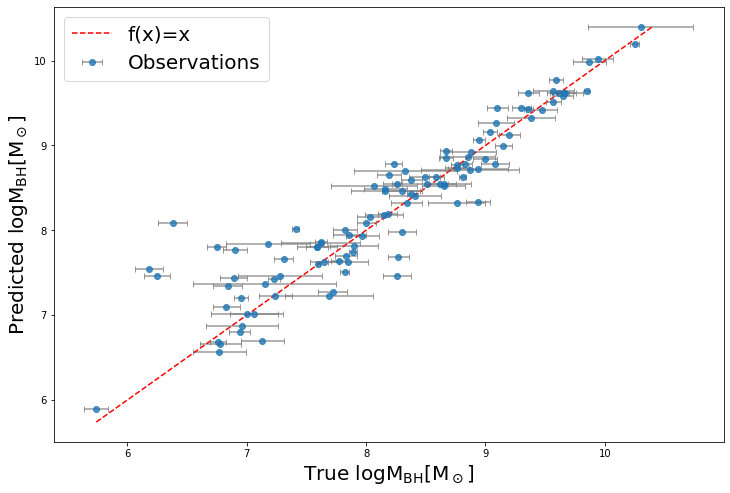

obs rmse: 0.3763593030428562
obs wrmse: 0.2555909819014655


In [75]:
plot_relation(['log_sigma0','log_R_e_sph_eq_kpc','logRho_soi_approx_new','bvtc'],sigma_r_rho_bvc_relation)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})=2.57 \log \sigma_0 + \log(B/T) - 0.43 \log \rho_\text{soi} - 0.24 \ \text{Pseudobulge} + 4.01
\end{equation}

In [76]:
def sigma_bt_rho_pseudobulge_relation(log_sigma0,log_BT,logRho_soi_approx_new,pseudobulge):    
    a=2.5665281441619349
    b=1.0
    c=-0.4279452531210189
    d=-0.2393228544761872
    e=4.0131431262964635
    return a*(log_sigma0)+b*(log_BT)+c*(logRho_soi_approx_new)+d*(pseudobulge)+e

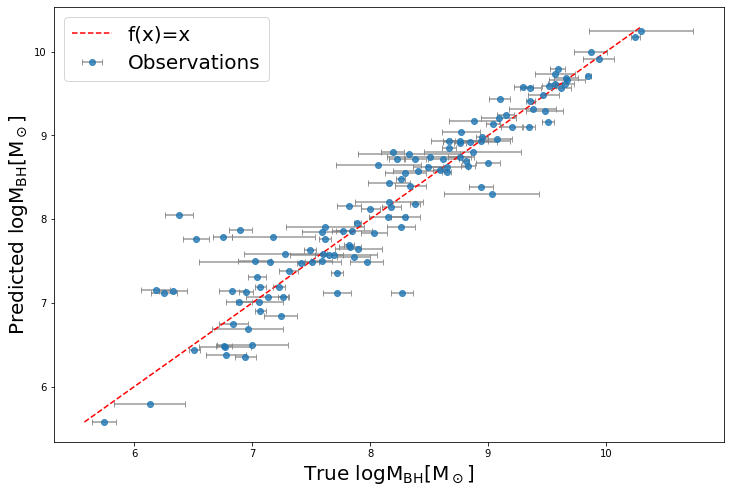

obs rmse: 0.379764263057725
obs wrmse: 0.22683915270235738


In [77]:
plot_relation(['log_sigma0','log_B/T','logRho_soi_approx_new','Pseudobulge'],sigma_bt_rho_pseudobulge_relation)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})=3 \log \sigma_0 - (\log \rho_\text{soi})^{0.58} + e^{\log(B/T)-\text{Pseudobulge}} + 2.55
\end{equation}

In [80]:
def sigma_rho_bt_pseudobulge_relation(x0,x4,x2,x7):
    a=3.0
    b=0.575925501030858
    c=2.547821423461232
    return a*x0-x4**b+np.exp(x2-x7)+c

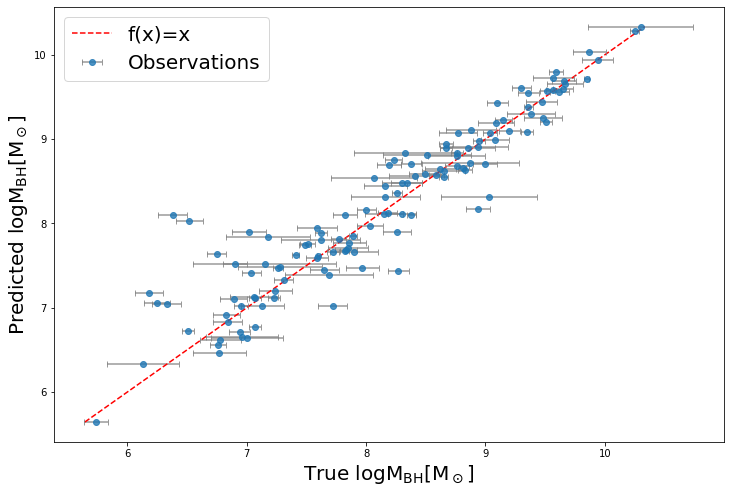

obs rmse: 0.3716117474849168
obs wrmse: 0.224195290778272


In [81]:
plot_relation(['log_sigma0','logRho_soi_approx_new','log_B/T','Pseudobulge'],sigma_rho_bt_pseudobulge_relation)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})=0.91 \log \text{M}^{*}_{\text{sph}} - 0.41(\log \rho_\text{soi}+\text{Pseudobulge}) - 0.27
\end{equation}

In [98]:
def Msph_rho_pseudobulge_relation(Msph,rho,pseudobulge):
    a=0.9074312354176397
    b=-0.406124683495805
    c=-0.2718555890272426
    return a*Msph+b*(rho+pseudobulge)+c

122


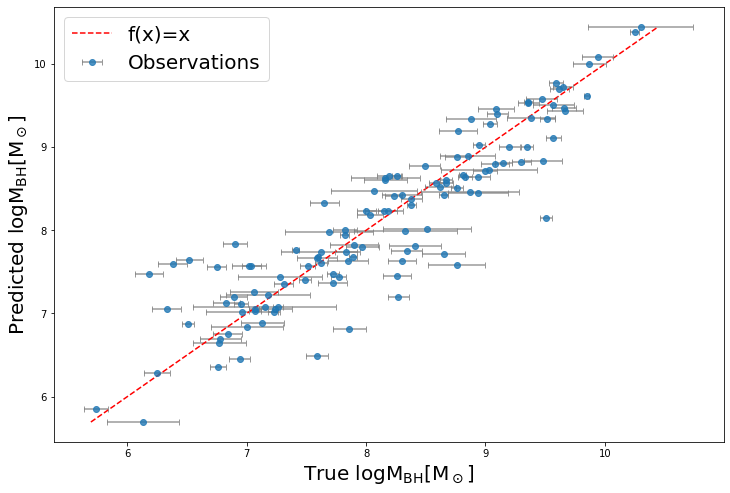

obs rmse: 0.43957556591596547
obs wrmse: 0.3042698714063203


In [100]:
plot_relation(['M*_sph','logRho_soi_approx_new','Pseudobulge'],Msph_rho_pseudobulge_relation)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})= \log \sigma_0 + 0.58 (\log \text{M}^{*}_{\text{sph}}+ \log (B/T))
\end{equation}

In [94]:
def sigma_Msph_BT_relation(sigma,Msph,BT):
    a=0.58404844826419349
    return sigma+a*(Msph+BT)

124


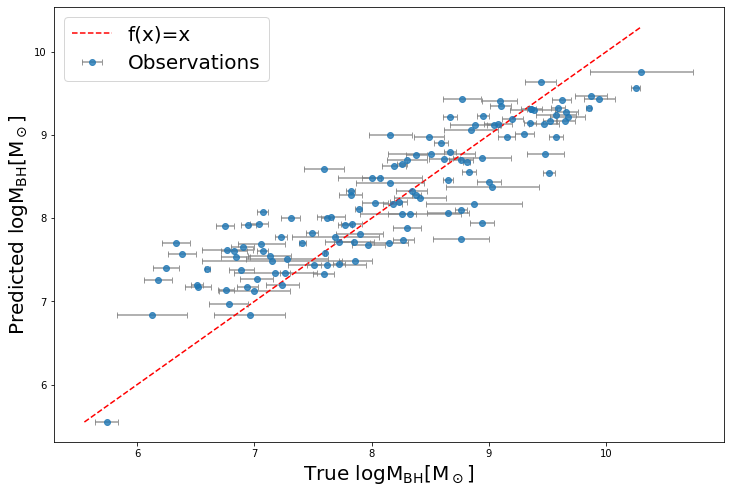

obs rmse: 0.5086334270535827
obs wrmse: 0.43345528947932416


In [97]:
plot_relation(['log_sigma0','M*_sph','log_B/T'],sigma_Msph_BT_relation)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})= \log L_{B}-\frac{1.73}{bvc}
\end{equation}

In [102]:
def blum_bvc_relation(blum,bvc):
    a=1.727784796655826
    return blum-(a/bvc)

122


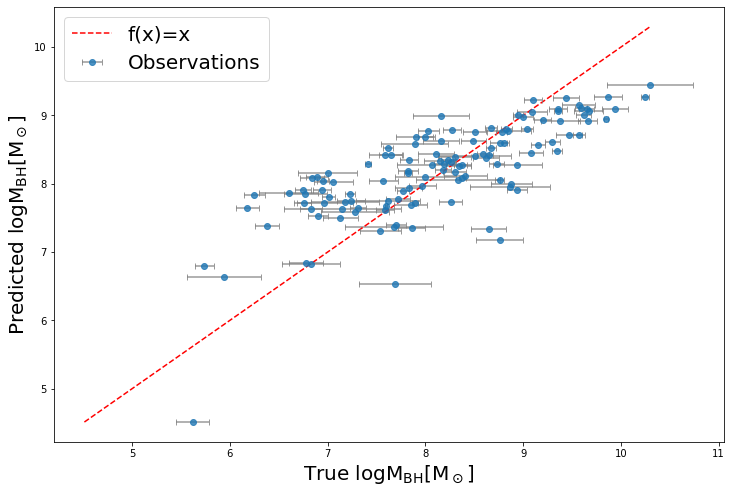

obs rmse: 0.6539092992330325
obs wrmse: 0.518232036988227


In [103]:
plot_relation(['logblum','bvtc'],blum_bvc_relation)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})= 0.44^{bvc} + \log L_{B} - 5.52
\end{equation}

In [104]:
def bvc_blum_relation(bvc,blum):
    a=4.444375083380111
    b=-5.52239593792091
    return a**bvc+blum+b

122


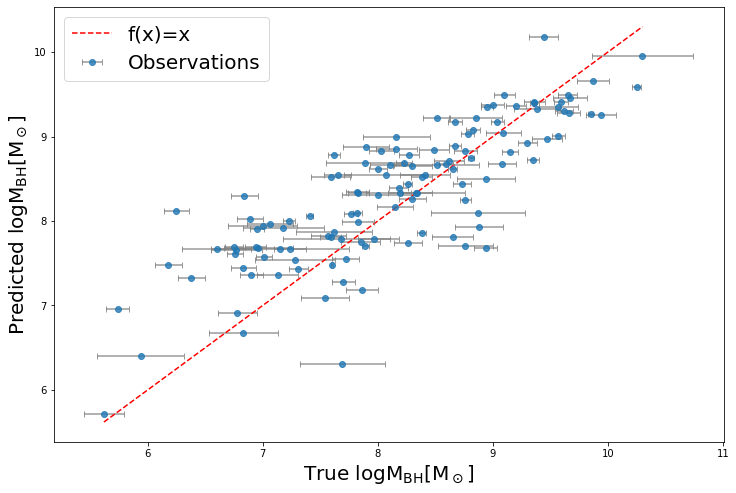

obs rmse: 0.6072793718720957
obs wrmse: 0.44358961729746454


In [105]:
plot_relation(['bvtc','logblum'],bvc_blum_relation)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})=\log \sigma_0 (3.61 + 0.23(\text{Core}-\text{Pseudobulge}))
\end{equation}

In [109]:
def sigma_core_pseudobulge(sigma,core,pseudobulge):
    a=0.23472318279549
    b=3.612014128255
    return sigma*(a*(core-pseudobulge)+b)

143


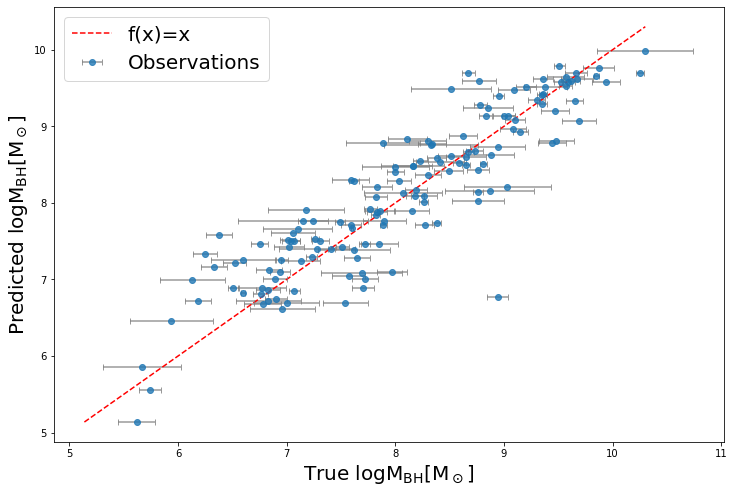

obs rmse: 0.47041836721076363
obs wrmse: 0.31063427354159756


In [110]:
plot_relation(['log_sigma0','Core','Pseudobulge'],sigma_core_pseudobulge)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})=4.14 \log \sigma_0 + 0.45 (\text{Core}-\text{Pseudobulge})-1.14
\end{equation}

In [111]:
def sigma_core_pseudobulge2(sigma,core,pseudobulge):
    a=4.135926771730385
    b=0.45114601637524224
    c=-1.1422301553820672
    return a*sigma+b*(core-pseudobulge)+c

143


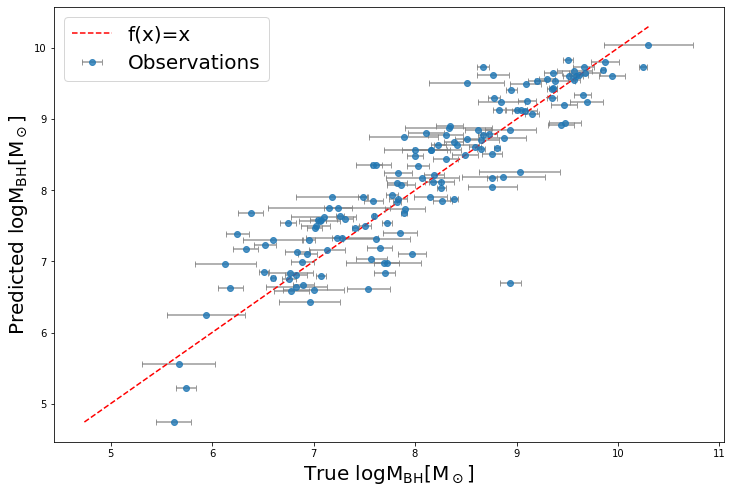

obs rmse: 0.48842462900688155
obs wrmse: 0.3122572996245162


In [112]:
plot_relation(['log_sigma0','Core','Pseudobulge'],sigma_core_pseudobulge2)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})= \log \text{M}^{*}_{\text{sph}} + 0.36 (\text{Core}-\text{Pseudobulge}) -2.42
\end{equation}

In [113]:
def Msph_core_pseudobulge(Msph,core,pseudobulge):
    a=0.36492546046497276
    b=-2.419965528706549
    return Msph+a*(core-pseudobulge)+b

124


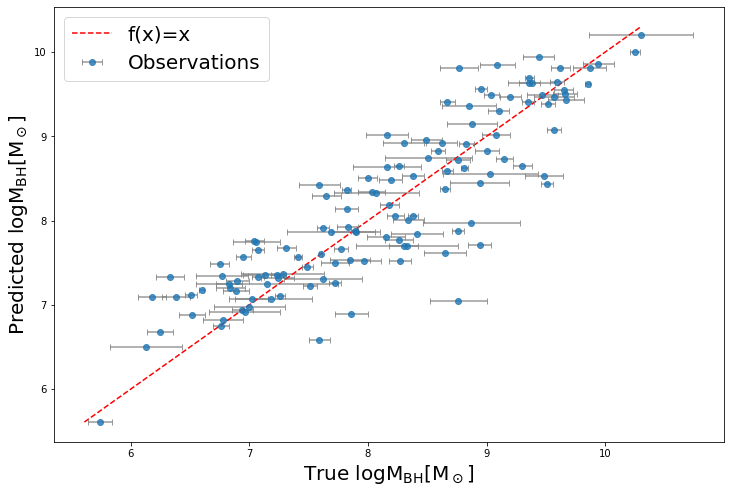

obs rmse: 0.4967758568648596
obs wrmse: 0.3632718495652039


In [116]:
plot_relation(['M*_sph','Core','Pseudobulge'],Msph_core_pseudobulge)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})= \log \text{M}^{*}_{\text{sph}} + 0.33 (\text{Core}-\text{Pseudobulge}) + 0.17 bvc -2.54
\end{equation}

In [117]:
def Msph_core_pseudobulge_bvc(Msph,core,pseudobulge,bvc):
    a=0.3346068919534675
    b=0.17447573368509578
    c=-2.5420715074368143
    return Msph+a*(core-pseudobulge)+b*bvc+c

105


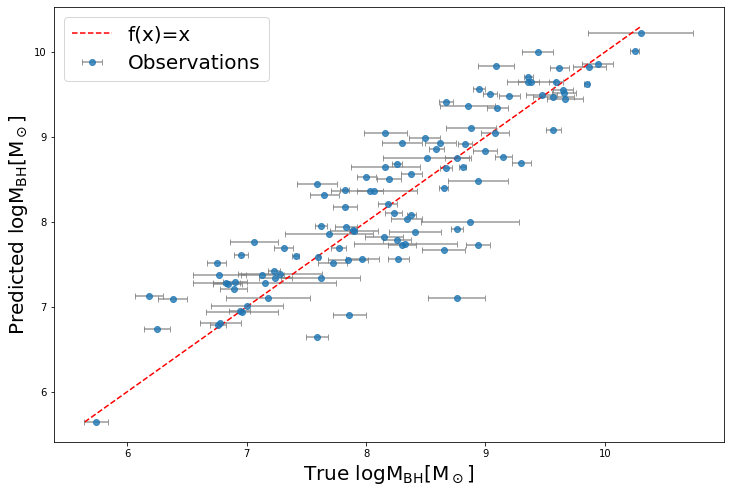

obs rmse: 0.4770054596188737
obs wrmse: 0.31053997487094576


In [119]:
plot_relation(['M*_sph','Core','Pseudobulge','bvtc'],Msph_core_pseudobulge_bvc)

\begin{equation}
\log (\frac{\text{M}_\text{BH}}{\text{M}_\odot})= \log R_e + 0.67 \text{Core} + bvc + 7.06
\end{equation}

In [121]:
def Re_core_bvc_relation(Re,core,bvc):
    a=0.66638191376642007
    b=7.063105852055458
    return Re+a*core+bvc+b

107


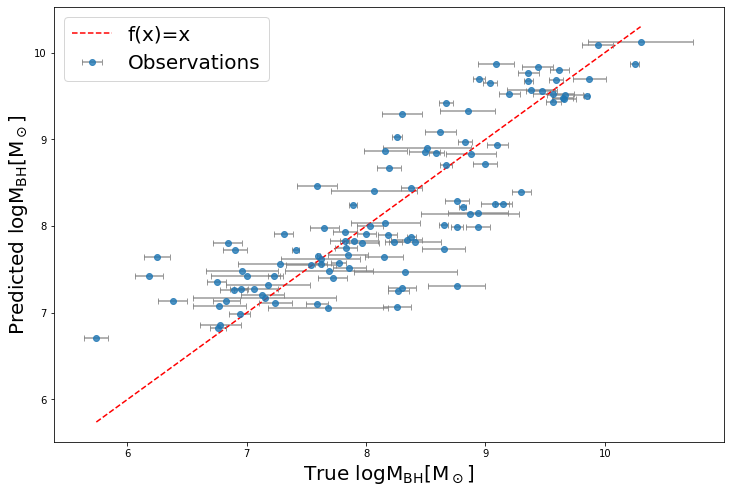

obs rmse: 0.5431876000081963
obs wrmse: 0.39393209165364523


In [123]:
plot_relation(['log_R_e_sph_eq_kpc','Core','bvtc'],Re_core_bvc_relation)